# Ripe and Rotte Mangoes: MLs.

El conjunto de datos Ripe y Rotten contiene imagenes que representan dos estados del mango. Este es un conjunto de datos multi-variables para determinar el estado de un mango a traves de una imagen.

El conjunto de datos contiene dos estados en los que se puede encontrar un mango que son: Ripe (Maduro) y Rotten (Podrido). Cada estado cuenta con una cantidad de ejemplos registrados. Rotten: 1492 imágenes y Ripe: 497 imágenes para un total de 1.989 ejemplos en el conjunto datos.

Debido a problemas de vectorización al intentar sacar la máscara binaria de las imagenes, se trabajara sólo con 294 másrasra de la clase Ripe y 541 de la clase Rotten, para un total de 835 ejemplos.

# Inspección inicial de los datos

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import os
from scipy.ndimage import binary_erosion
import skimage as ski
from skimage import measure
import statistics
from skimage.data import page
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops
from scipy.stats import skew, kurtosis

Función encargada de buscar la ruta de las carpetas que contienen el conjunto de datos, en este caso las mascaras y de recorrer cada item para cargarlas en una lista: data_mask[].

In [5]:
path_ripe = "ripe_masks"
path_rotten = "rotten_masks"

data_mask = []

def load_images_from_folder(folder_path, label):
    loaded_masks = []

    if not os.path.exists(folder_path):
        print(f"La carpeta {folder_path} no existe")
        return loaded_masks

    files = os.listdir(folder_path)
    npy_files = [f for f in files if f.endswith('.npy')]
    
    if not npy_files:
        print(f"No se encontraron archivos .npy en {folder_path}")
        return loaded_masks
    
    # Cargar cada archivo .npy
    for filename in npy_files:
        try:
            mask_path = os.path.join(folder_path, filename)
            mask = np.load(mask_path)
            loaded_masks.append({
                'mask': mask,
                'label': label,
                'mask_path': mask_path
            })
            # print(f"Cargada máscara: {filename}")
        except Exception as e:
            print(f"Error al cargar {filename}: {str(e)}")
    
    return loaded_masks


A continuación vamos a buscar extraer las propiedades más importantes de la máscara que pueden guardar relación con el estado del mango a través de la libreria regionprops. Esta función, recibe como argumento la máscara binaria del mango en forma de array y retorna un diccionario con las propiedades que fueron extraídas. Se realizan los respectivos cálculos derivados, se definen las coordenadas para los calculos estadisticos. Dentro de estas propiedades se encuentran: Propiedades básicas como el área, el perimetro, excentricidad y la solidez, propiedades derivadas, como el área convexa, estadisticas de forma, momentos de Hu y estadisticas de distribución espacial. 

In [7]:
def extract_mask_properties(mask):
    # Asegurar que la máscara sea binaria y esté en el formato correcto
    mask = mask.astype(bool).astype(np.uint8)
    
    # Validar que la máscara no esté vacía
    if np.sum(mask) == 0:
        return None
    
    if mask.ndim > 2:
        mask = np.max(mask, axis=0)
    
    # Asegurar que hay al menos un objeto en la máscara
    props_list = regionprops(mask)
    if not props_list:
        return None
    
    props = props_list[0]  # Tomar el objeto más grande si hay varios
    
    # Obtener coordenadas de los píxeles del objeto
    coords = np.column_stack(np.where(mask))
    
    try:
        # Cálculos derivados básicos con manejo de excepciones
        form_factor = 4 * np.pi * props.area / (props.perimeter ** 2) if props.perimeter > 0 else 0
        aspect_ratio = props.major_axis_length / props.minor_axis_length if props.minor_axis_length > 0 else 0
        
        # Calcular GLCM con valores binarios
        glcm = graycomatrix(mask, 
                           distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                           levels=2,
                           symmetric=True, 
                           normed=True)
        
        # Características de textura
        contrast = graycoprops(glcm, 'contrast')[0].mean()
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0].mean()
        homogeneity = graycoprops(glcm, 'homogeneity')[0].mean()
        energy = graycoprops(glcm, 'energy')[0].mean()
        correlation = graycoprops(glcm, 'correlation')[0].mean()
        
        # Análisis de contorno optimizado para máscaras binarias
        contours = measure.find_contours(mask, 0.5)
        if contours:
            main_contour = contours[0]
            # Suavizar el contorno para cálculos más robustos
            if len(main_contour) > 3:  # Necesitamos al menos 4 puntos para calcular curvatura
                dx = np.gradient(main_contour[:, 1])
                dy = np.gradient(main_contour[:, 0])
                d2x = np.gradient(dx)
                d2y = np.gradient(dy)
                curvature = np.abs(dx * d2y - dy * d2x) / (dx * dx + dy * dy)**1.5
                mean_curvature = np.nanmean(curvature[np.isfinite(curvature)])
                std_curvature = np.nanstd(curvature[np.isfinite(curvature)])
            else:
                mean_curvature = 0
                std_curvature = 0
        else:
            mean_curvature = 0
            std_curvature = 0
            
        # Calcular píxeles del borde usando binary_erosion
        boundary_pixels = np.sum(mask - binary_erosion(mask))
            
        properties = {
            # Propiedades geométricas básicas
            'area': float(props.area),
            'perimeter': float(props.perimeter),
            'eccentricity': float(props.eccentricity),
            'solidity': float(props.solidity),
            'major_axis_length': float(props.major_axis_length),
            'minor_axis_length': float(props.minor_axis_length),
            'orientation': float(props.orientation),
            'extent': float(props.extent),
            'form_factor': float(form_factor),
            'aspect_ratio': float(aspect_ratio),
            'convex_area': float(props.convex_area),
            'filled_area': float(props.filled_area),
            'euler_number': int(props.euler_number),
            'equivalent_diameter': float(props.equivalent_diameter),
            'bbox_area': float(props.bbox_area),
            
            # Momentos de Hu
            'hu_moment_1': float(props.moments_hu[0]),
            'hu_moment_2': float(props.moments_hu[1]),
            'hu_moment_3': float(props.moments_hu[2]),
            'hu_moment_4': float(props.moments_hu[3]),
            
            # Estadísticas espaciales
            'skewness_x': float(skew(coords[:, 0])) if len(coords) > 0 else 0,
            'skewness_y': float(skew(coords[:, 1])) if len(coords) > 0 else 0,
            'kurtosis_x': float(kurtosis(coords[:, 0])) if len(coords) > 0 else 0,
            'kurtosis_y': float(kurtosis(coords[:, 1])) if len(coords) > 0 else 0,
            
            # Características de textura
            'glcm_contrast': float(contrast),
            'glcm_dissimilarity': float(dissimilarity),
            'glcm_homogeneity': float(homogeneity),
            'glcm_energy': float(energy),
            'glcm_correlation': float(correlation),
            
            # Características de contorno
            'mean_curvature': float(mean_curvature),
            'std_curvature': float(std_curvature),
            
            # Medidas de compacidad
            'compactness': float(props.area / (props.perimeter * props.perimeter)) if props.perimeter > 0 else 0,
            'roundness': float((4 * props.area) / (np.pi * props.major_axis_length**2)) if props.major_axis_length > 0 else 0,
            
            # Propiedades de intensidad para máscaras binarias
            'total_pixels': int(np.prod(mask.shape)),
            'fraction_occupied': float(np.sum(mask) / np.prod(mask.shape)),
            'boundary_pixels': int(boundary_pixels),
            'centroid_x': float(props.centroid[0]),
            'centroid_y': float(props.centroid[1])
        }
        
        return properties
        
    except Exception as e:
        print(f"Error processing mask: {str(e)}")
        return None

Además, también devuelve algunas caracteristicas relacionadas con la textura: glcm_contrast, glcm_dissimilarity, glcm_homogeneity, glcm_energy, glcm_correlation utilizando graycoprops de skimage. Con el contorno: mean_curvature y std_curvature. 
Propiedades de intensidad como: total_pixels, fraction_occupied, boundary_pixels, centroid_x y centroid_y.

Luego, tenemos la siguiente función que se encargara de recorrer el dataframe que contiene todas las mascaras y aplicar las dos funciones anteriores. Analizando el conjunto de datos completo.

In [13]:
def analyze_masks_dataset(path_ripe, path_rotten):
    # Cargar las máscaras de ambas carpetas
    ripe_masks = load_images_from_folder(path_ripe, 'Ripe')
    rotten_masks = load_images_from_folder(path_rotten, 'Rotten')
    
    # Combinar todas las máscaras
    all_masks = ripe_masks + rotten_masks
    
    if not all_masks:
        print("No se encontraron máscaras para analizar")
        return None
    
    print(f"Total de máscaras cargadas: {len(all_masks)}")
    
    # Extraer propiedades de cada máscara
    properties_list = []
    for idx, mask_data in enumerate(all_masks):
        try:
            properties = extract_mask_properties(mask_data['mask'])
            if properties is not None:
                properties['label'] = mask_data['label']
                properties['mask_path'] = mask_data['mask_path']
                properties_list.append(properties)
            else:
                print(f"Advertencia: No se pudieron extraer propiedades de la máscara {idx}")
        except Exception as e:
            print(f"Error procesando máscara {idx}: {str(e)}")
    
    # Crear DataFrame de propiedades
    if properties_list:
        df_properties = pd.DataFrame(properties_list)
        print(f"Se procesaron exitosamente {len(df_properties)} máscaras")
        return df_properties
    else:
        print("No se pudieron procesar las máscaras correctamente")
        return None

Como se puede observar, esta función realiza la carga de las máscaras binarias y almacena en un dataframe las propiedades con las etiquetas que clasifican al mango. 

Luego, tenemos la siguiente función que se encarga de dibujar un histograma que representa la cantidad de datos de cada clase.

In [17]:
def plot_class_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title("Distribución de Clases: Ripe vs Rotten")
    plt.xlabel("Estado del Mango")
    plt.ylabel("Cantidad")
    plt.show()
def visualize_properties(df):
    print("1. Distribución de clases")
    plot_class_distribution(df)
    

Finalmente, llamaremos a la función analyze_masks_dataset para obtener los datos y propiedades de cada máscara en un dataframe y visualizar el diagrama de clases.

Total de máscaras cargadas: 835
Se procesaron exitosamente 835 máscaras
1. Distribución de clases


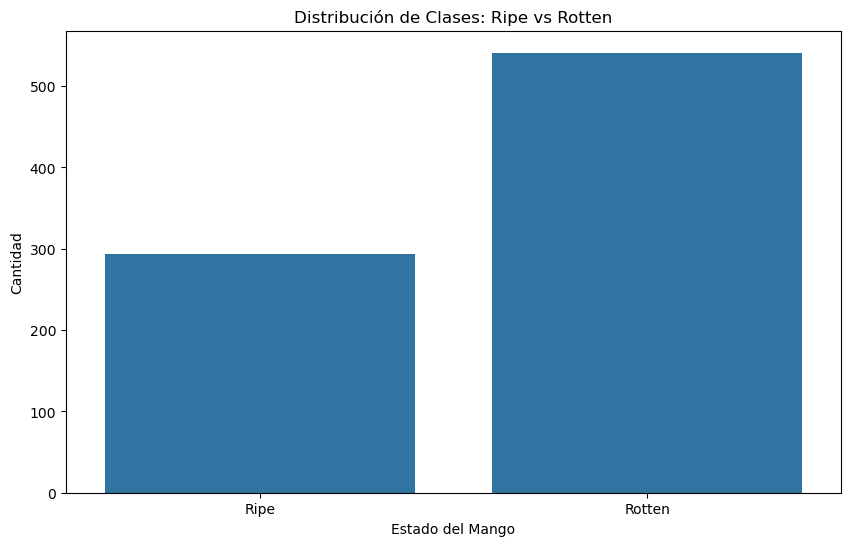

In [20]:
df_properties = analyze_masks_dataset(path_ripe, path_rotten)
visualize_properties(df_properties)


Realizamos una inspección de las columnas de nuestro dataframe que contiene las propiedades extraídas de cada máscara.

In [22]:
df_properties.drop('mask_path', axis=1)
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area                 835 non-null    float64
 1   perimeter            835 non-null    float64
 2   eccentricity         835 non-null    float64
 3   solidity             835 non-null    float64
 4   major_axis_length    835 non-null    float64
 5   minor_axis_length    835 non-null    float64
 6   orientation          835 non-null    float64
 7   extent               835 non-null    float64
 8   form_factor          835 non-null    float64
 9   aspect_ratio         835 non-null    float64
 10  convex_area          835 non-null    float64
 11  filled_area          835 non-null    float64
 12  euler_number         835 non-null    int64  
 13  equivalent_diameter  835 non-null    float64
 14  bbox_area            835 non-null    float64
 15  hu_moment_1          835 non-null    flo

Ahora se hace una visualización de la media, la varianza, los minimos, maximos y los percentiles de cada una de las variables extraídas en el dataframe.

In [26]:
df_properties.describe()

,area,perimeter,eccentricity,solidity,major_axis_length,minor_axis_length,orientation,extent,form_factor,aspect_ratio,...,glcm_correlation,mean_curvature,std_curvature,compactness,roundness,total_pixels,fraction_occupied,boundary_pixels,centroid_x,centroid_y
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,...,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,8693.228743,717.858988,0.733858,0.872158,153.539585,69.180250,-0.017099,0.776798,0.137490,20.554737,...,0.943557,0.807943,0.501909,0.010941,0.513016,37931.422754,0.317862,759.467066,121.943184,80.668426
std,21288.467925,580.975567,0.227909,0.125351,127.986842,62.897575,0.444020,0.161148,0.051154,44.058679,...,0.037442,0.619259,0.367171,0.004071,0.355017,42187.467691,0.248593,622.513856,62.933702,63.502712
min,168.000000,114.000000,0.118514,0.138145,64.652920,3.265986,-1.565546,0.085462,0.006920,1.007098,...,0.243213,0.000000,0.000000,0.000551,0.002106,558.000000,0.057816,114.000000,59.432503,1.000000
25%,603.000000,405.000000,0.574138,0.846548,101.607086,3.265986,-0.260495,0.700378,0.102335,1.221369,...,0.927483,0.000000,0.000000,0.008144,0.032559,672.000000,0.133839,405.000000,101.147217,1.000000
50%,6022.000000,681.298557,0.739675,0.872239,120.759305,76.700193,0.000000,0.737153,0.149600,1.485964,...,0.936798,0.951949,0.633386,0.011905,0.657046,50176.000000,0.205098,721.000000,112.479238,104.260833
75%,8879.000000,853.550865,0.999483,0.974790,150.632740,95.957148,0.096679,0.974790,0.174282,31.110689,...,0.971843,1.482843,0.793470,0.013869,0.801426,50176.000000,0.428571,907.500000,125.782321,120.433605
max,313453.000000,8286.676221,0.999998,1.000000,1570.392308,578.299534,1.567872,1.000000,0.290326,480.832481,...,1.000000,1.482843,1.037702,0.023103,0.965919,537975.000000,1.000000,8974.000000,815.500000,423.899551


# Inspección de datos nulos

In [29]:
df_properties.isna().sum() #Para observar si hay datos nulos en el dataset

area                   0
perimeter              0
eccentricity           0
solidity               0
major_axis_length      0
minor_axis_length      0
orientation            0
extent                 0
form_factor            0
aspect_ratio           0
convex_area            0
filled_area            0
euler_number           0
equivalent_diameter    0
bbox_area              0
hu_moment_1            0
hu_moment_2            0
hu_moment_3            0
hu_moment_4            0
skewness_x             0
skewness_y             0
kurtosis_x             0
kurtosis_y             0
glcm_contrast          0
glcm_dissimilarity     0
glcm_homogeneity       0
glcm_energy            0
glcm_correlation       0
mean_curvature         0
std_curvature          0
compactness            0
roundness              0
total_pixels           0
fraction_occupied      0
boundary_pixels        0
centroid_x             0
centroid_y             0
label                  0
mask_path              0
dtype: int64

Como se puede observar no existen datos nulos en el dataframe.

## Distribución de las variables predictoras

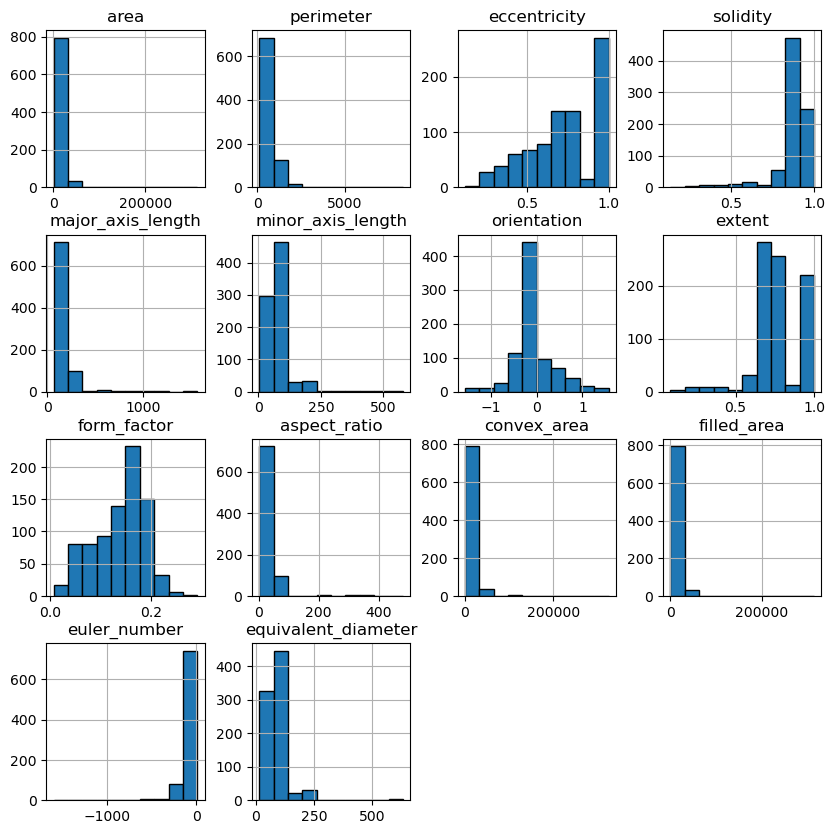

In [33]:
df_properties.hist(['area', 'perimeter', 'eccentricity', 'solidity', 'major_axis_length','minor_axis_length','orientation','extent','form_factor','aspect_ratio','convex_area','filled_area','euler_number',
            'equivalent_diameter'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

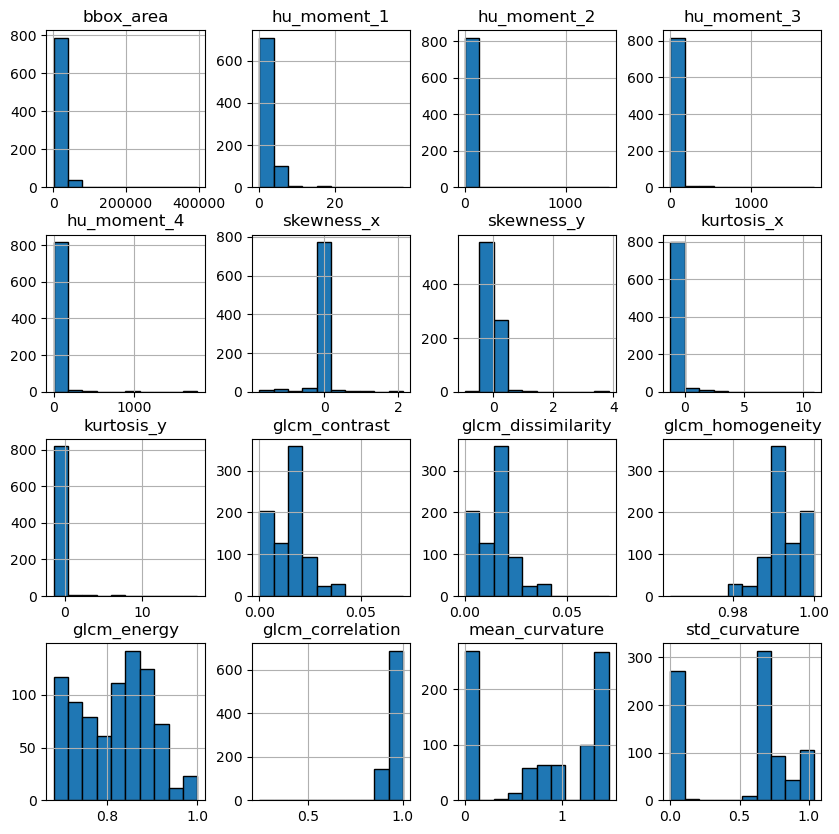

In [34]:
df_properties.hist(['bbox_area','hu_moment_1','hu_moment_2','hu_moment_3','hu_moment_4','skewness_x','skewness_y','kurtosis_x','kurtosis_y','glcm_contrast',
            'glcm_dissimilarity','glcm_homogeneity','glcm_energy','glcm_correlation','mean_curvature','std_curvature'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()



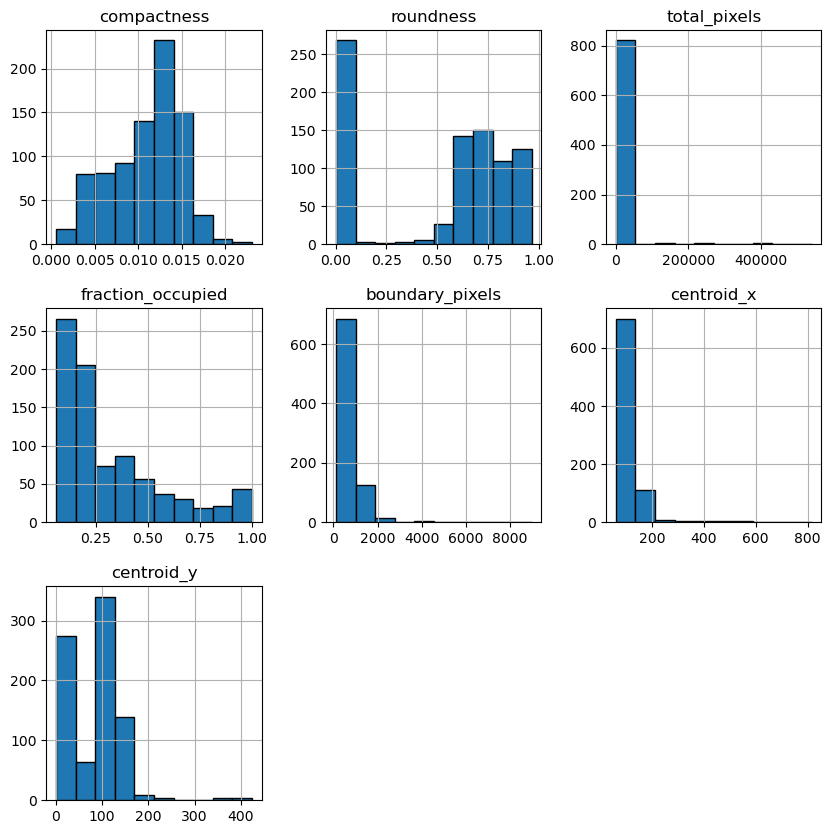

In [37]:
df_properties.hist(['compactness','roundness','total_pixels','fraction_occupied',
            'boundary_pixels','centroid_x','centroid_y'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()


Observando la distribución de cada variable, podemos decir, que no poseen distribución normal.

## Inspección de las variables predictoras correlacionadas

Iniciamos separando las variables predictoras de la variable a predecir.

In [42]:
X = df_properties.drop(['label', 'mask_path'], axis=1) # Separa las variables predictoras de las variable a predecir
y = df_properties['label']

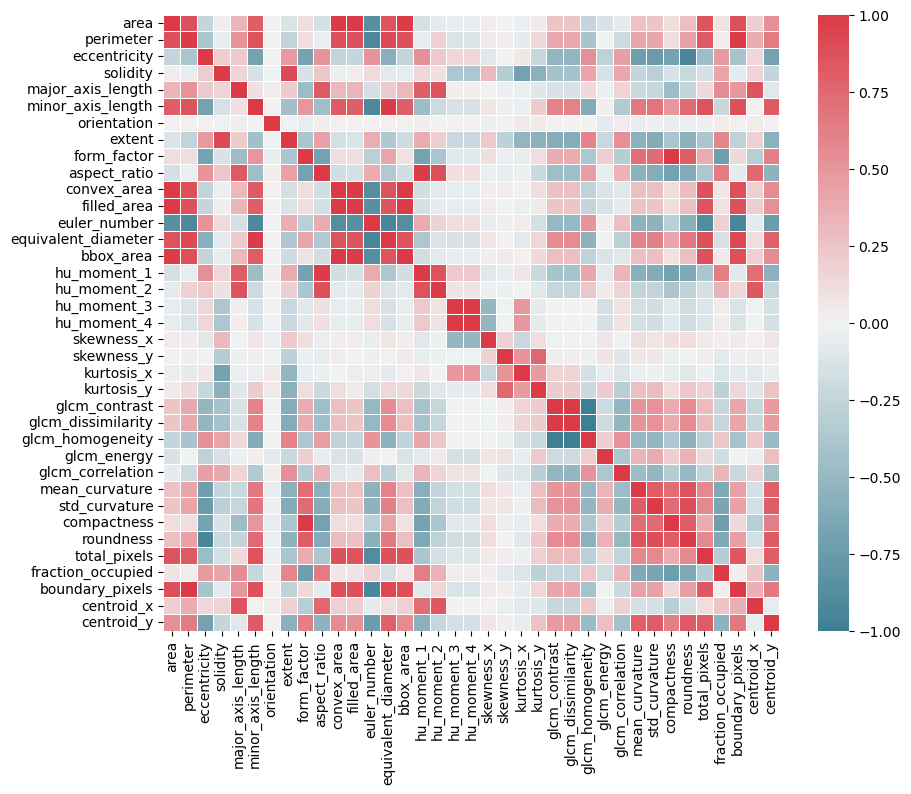

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), 
          cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax, linewidths=.5)
plt.show()

Viendo el mapa de calor realizado con heatmap, podemos decir a simple vista que existen variables demasiado correlacionadas. Por ello, con la siguiente función que recibe el dataframe, se analizará que variables están fuertemente correlacionadas para tomar medidas.

In [47]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups

In [49]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')

      feature1     feature2  corr
0  compactness  form_factor   1.0 

        feature1          feature2  corr
2  glcm_contrast  glcm_homogeneity   1.0 

             feature1          feature2  corr
3  glcm_dissimilarity  glcm_homogeneity   1.0 

      feature1     feature2  corr
6  hu_moment_3  hu_moment_4   1.0 

       feature1     feature2      corr
8   filled_area         area  1.000000
14  filled_area  convex_area  0.996253
19  filled_area    bbox_area  0.990891 

     feature1         feature2      corr
10  perimeter  boundary_pixels  0.999308 

       feature1      feature2      corr
22  hu_moment_1  aspect_ratio  0.987643 

               feature1           feature2      corr
24  equivalent_diameter  minor_axis_length  0.984795 



Se puede observar en el análisis que existen bastantes variables que se encuentran fuertemente correlacionadas. A raiz de esto, miraremos con un gráfico de dispersión cada variable.

array([[<Axes: xlabel='compactness', ylabel='compactness'>,
        <Axes: xlabel='form_factor', ylabel='compactness'>,
        <Axes: xlabel='glcm_homogeneity', ylabel='compactness'>,
        <Axes: xlabel='glcm_contrast', ylabel='compactness'>,
        <Axes: xlabel='glcm_dissimilarity', ylabel='compactness'>,
        <Axes: xlabel='hu_moment_3', ylabel='compactness'>,
        <Axes: xlabel='hu_moment_4', ylabel='compactness'>,
        <Axes: xlabel='filled_area', ylabel='compactness'>,
        <Axes: xlabel='area', ylabel='compactness'>,
        <Axes: xlabel='convex_area', ylabel='compactness'>,
        <Axes: xlabel='perimeter', ylabel='compactness'>,
        <Axes: xlabel='bbox_area', ylabel='compactness'>,
        <Axes: xlabel='boundary_pixels', ylabel='compactness'>,
        <Axes: xlabel='hu_moment_1', ylabel='compactness'>,
        <Axes: xlabel='aspect_ratio', ylabel='compactness'>,
        <Axes: xlabel='equivalent_diameter', ylabel='compactness'>,
        <Axes: xlabel='m

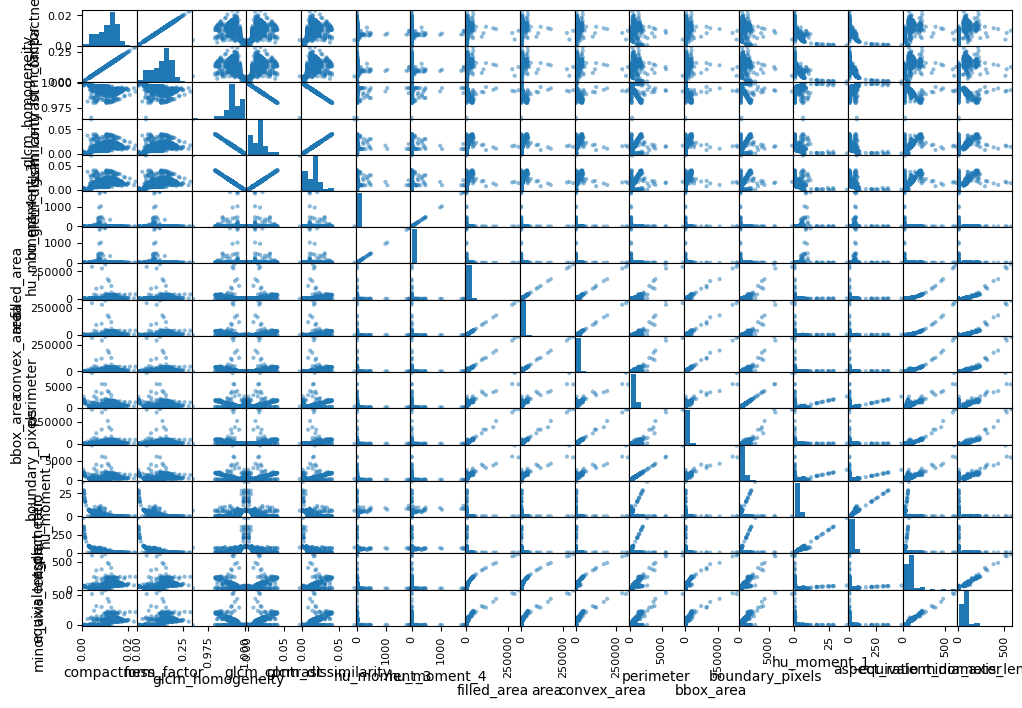

In [52]:
from pandas.plotting import scatter_matrix

cols = ['compactness', 'form_factor', "glcm_homogeneity", 'glcm_contrast', 'glcm_dissimilarity', 'hu_moment_3', 'hu_moment_4', 'filled_area', 'area', 'convex_area', 'perimeter', 'bbox_area', 'boundary_pixels', 'hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']
scatter_matrix(X[cols], figsize=(12, 8))

No se logra ver correctamente el gráfico, debido a que son muchas variables, por ello vamos a estar análizando con un mapas de calor.

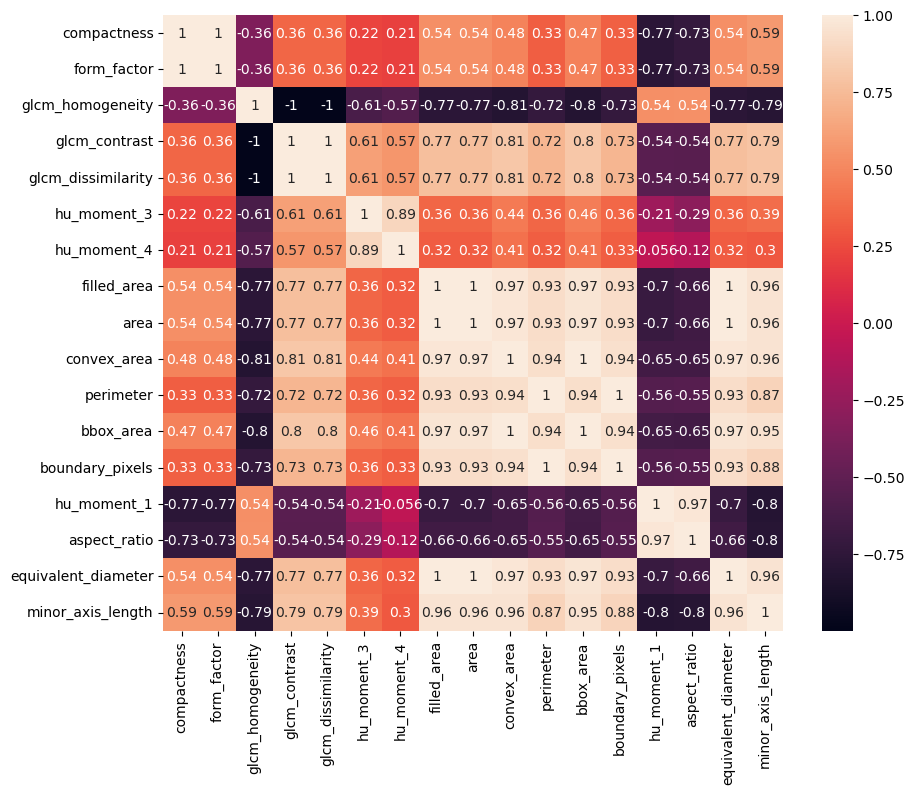

In [54]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X[['compactness', 'form_factor', "glcm_homogeneity", 'glcm_contrast', 'glcm_dissimilarity', 'hu_moment_3', 'hu_moment_4', 'filled_area', 'area','convex_area', 'perimeter', 'bbox_area', 'boundary_pixels', 'hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

Como se logra ver, filled_area guarda correlación con las variables de area, convex_area, equivalent_diameter y bbox_area, por tanto, será descartada del estudio.
Volvemos a dibujar el mapa para las variables que poseian alta correlación.

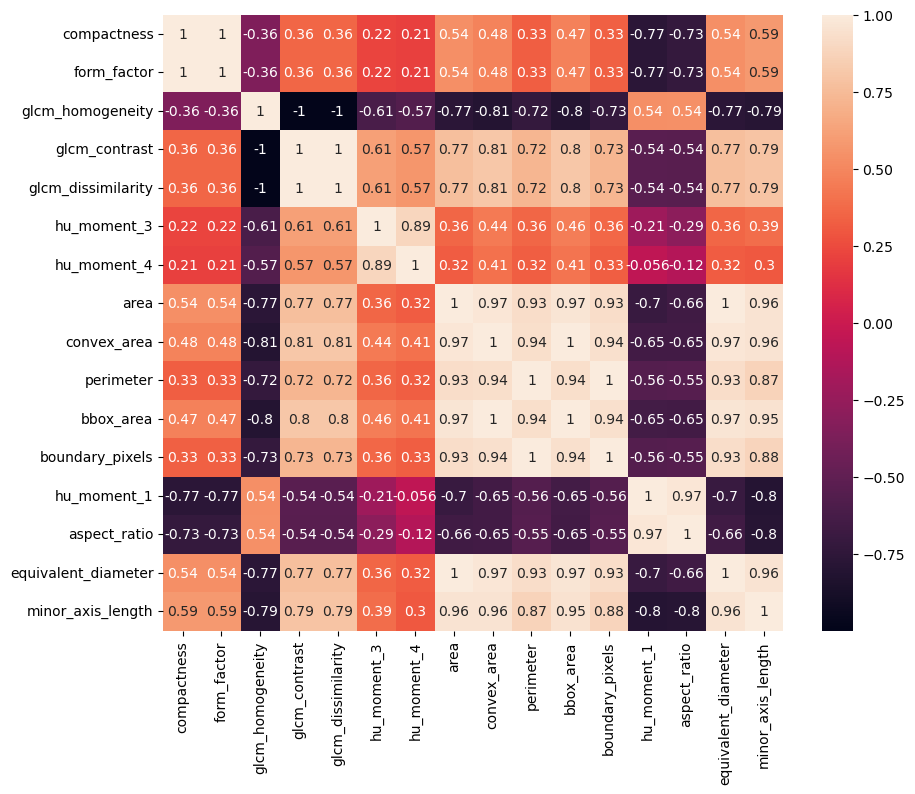

In [58]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X[['compactness', 'form_factor', "glcm_homogeneity", 'glcm_contrast', 'glcm_dissimilarity', 'hu_moment_3', 'hu_moment_4', 'area','convex_area', 'perimeter', 'bbox_area', 'boundary_pixels', 'hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

Como se ve, de nuevo, las variables area y equivalent_diameter también guardan una correción de 1. Lo mismo ocurre para compactness y form_factor, bbox_area y convext_area, glcm_contrast y glcm_dissimilarity. Por tanto, se eliminará una de cada correlación fuerte.

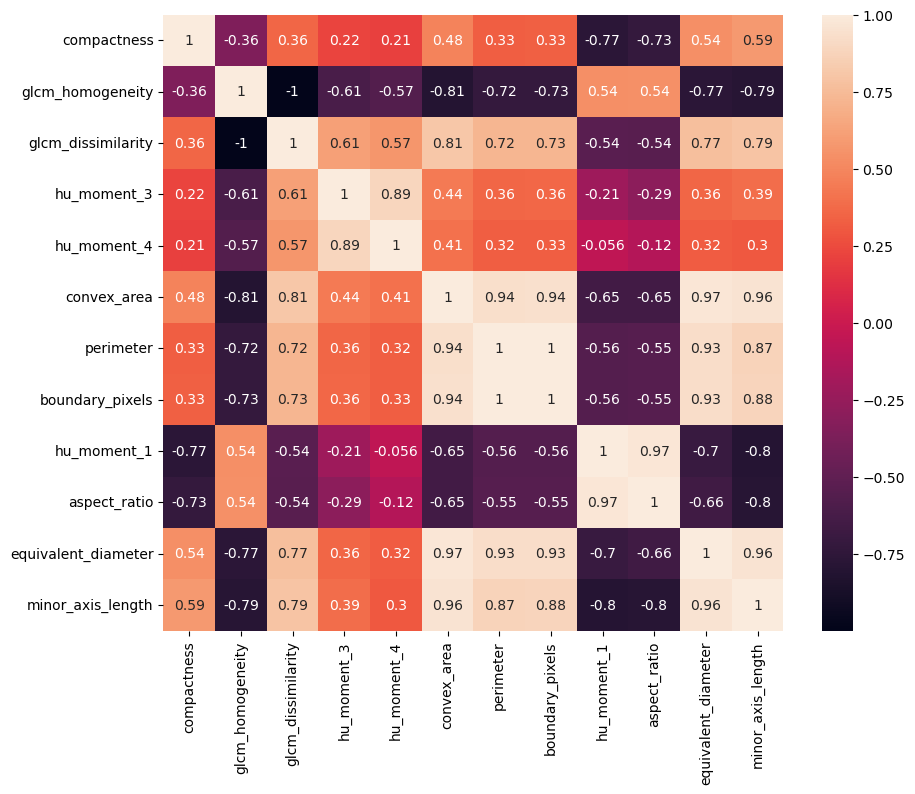

In [61]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X[['compactness', "glcm_homogeneity", 'glcm_dissimilarity', 'hu_moment_3', 'hu_moment_4','convex_area', 'perimeter', 'boundary_pixels', 'hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

Se sigue observando correlación fuerte entre las variables perimeter y boundary_pixeles. Por ello, será eliminada perimeter.

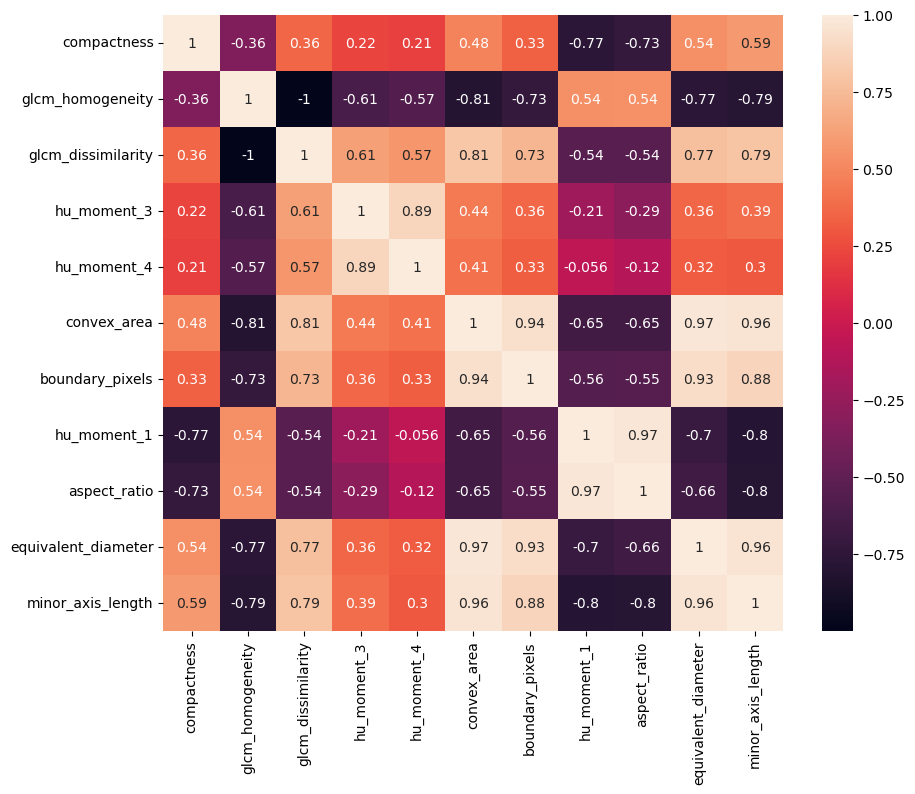

In [64]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X[['compactness', "glcm_homogeneity", 'glcm_dissimilarity', 'hu_moment_3', 'hu_moment_4','convex_area', 'boundary_pixels', 'hu_moment_1', 'aspect_ratio', 'equivalent_diameter', 'minor_axis_length']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show() 

Como observamos estas variables que presentaban correlación, no sostienen una tan fuerte como las que fueron sacadas del estudio.
A continuación, eliminaremos las variables que fueron descartadas, y volveremos a realizar el análisis de correlación.

In [67]:
X.drop(['area', 'filled_area', 'form_factor', 'perimeter', 'bbox_area', 'glcm_contrast'], axis=1, inplace = True) 
#Elimina las variables correlacionadas del estudio

Volvemos a hacer un análisis de correlación entre las variables con la función corr_feature_detect()

In [70]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')

             feature1          feature2  corr
0  glcm_dissimilarity  glcm_homogeneity   1.0 

      feature1     feature2  corr
2  hu_moment_3  hu_moment_4   1.0 

       feature1     feature2      corr
4  aspect_ratio  hu_moment_1  0.987643 

              feature1           feature2      corr
6  equivalent_diameter  minor_axis_length  0.984795 



Eliminaremos del estudio una de las que se encuentren con correlación de 1 o por encima de 0.97. Es decir, sacaremos glcm_dissimilarity,  hu_moment_4, hu_moment_1 y equivalent_diameter

In [73]:
X.drop(['glcm_dissimilarity', 'hu_moment_4', 'hu_moment_1','equivalent_diameter'], axis=1, inplace = True) 
#Elimina las variables correlacionadas del estudio

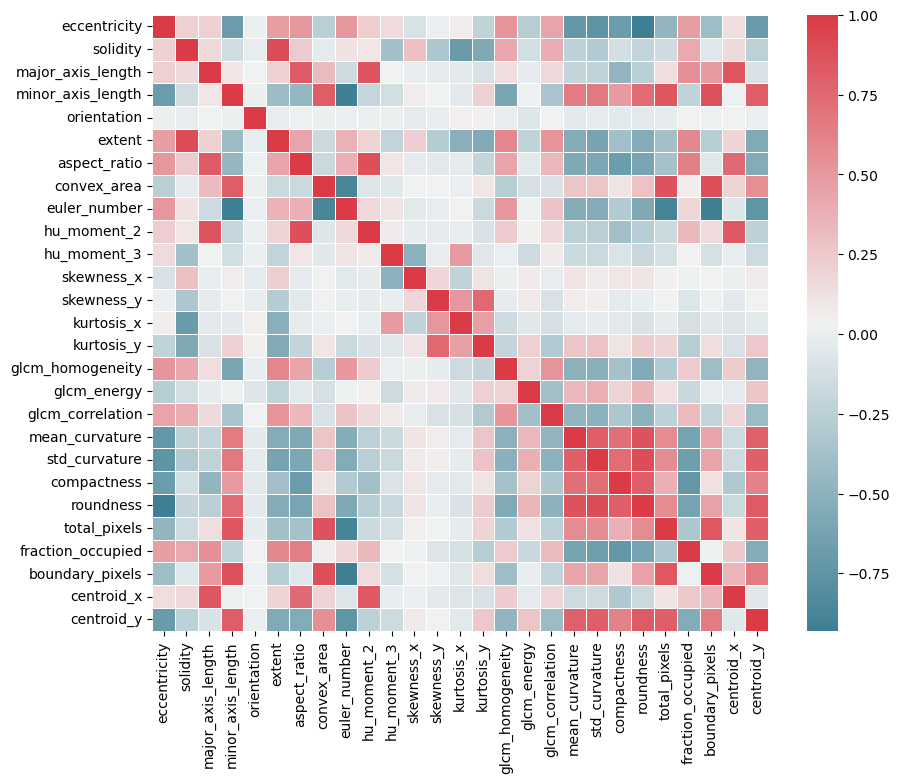

In [75]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), 
          cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax, linewidths=.5)
plt.show()

Como se observa, ya no existen relaciones tan fuertes entre las variables que se conservaron.
Volvemos a verificar la correlación: 

In [78]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')

No hay variables fuertemente correlacionadas. 


### Eliminación de variables correlacionadas del dataframe principal

Ahora eliminaremos del dataframe principal(df_properties) las variables que decidimos sacar el estudio: area, filled_area, form_factor, perimeter, bbox_area, glcm_contrast,  glcm_dissimilarity, hu_moment_4, hu_moment_1 y equivalent_diameter

In [83]:
df_properties = df_properties.drop(['area', 'filled_area', 'perimeter', 'bbox_area', 'glcm_contrast', 'glcm_dissimilarity','hu_moment_4','hu_moment_1','equivalent_diameter', 'mask_path'], axis=1)

In [85]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   eccentricity       835 non-null    float64
 1   solidity           835 non-null    float64
 2   major_axis_length  835 non-null    float64
 3   minor_axis_length  835 non-null    float64
 4   orientation        835 non-null    float64
 5   extent             835 non-null    float64
 6   form_factor        835 non-null    float64
 7   aspect_ratio       835 non-null    float64
 8   convex_area        835 non-null    float64
 9   euler_number       835 non-null    int64  
 10  hu_moment_2        835 non-null    float64
 11  hu_moment_3        835 non-null    float64
 12  skewness_x         835 non-null    float64
 13  skewness_y         835 non-null    float64
 14  kurtosis_x         835 non-null    float64
 15  kurtosis_y         835 non-null    float64
 16  glcm_homogeneity   835 non

Como se logra observar quedamos con un total de 27 variables predictoras del estado del mango.

## Selección de caracteristicas: Utilizando feature selection de Sickit-learn

Utilizamos un modelo de Random Forest Classifier como estimador para un Sequential Feature Selector (SFS), para la seleccion de las caracteriscas que optimizen el modelo. En nuestro caso, se usan 30 árboles de decisión en el bosque aleatorio para estimar 18 caracteristicas se mejoren el rendimiento del modelo.

In [91]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [93]:
RF = RandomForestClassifier(n_estimators=30, n_jobs = -1)
sfs = SequentialFeatureSelector(RF, n_features_to_select=18)
sfs.fit(X, y)

sfs.get_feature_names_out()

array(['eccentricity', 'solidity', 'minor_axis_length', 'orientation',
       'extent', 'euler_number', 'skewness_x', 'skewness_y', 'kurtosis_x',
       'kurtosis_y', 'glcm_homogeneity', 'glcm_correlation',
       'mean_curvature', 'std_curvature', 'fraction_occupied',
       'boundary_pixels', 'centroid_x', 'centroid_y'], dtype=object)

Lo que haremos ahora, es eliminar las variables que no fueron seleccionadas por SequentialFeatureSelector.

In [95]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   eccentricity       835 non-null    float64
 1   solidity           835 non-null    float64
 2   major_axis_length  835 non-null    float64
 3   minor_axis_length  835 non-null    float64
 4   orientation        835 non-null    float64
 5   extent             835 non-null    float64
 6   aspect_ratio       835 non-null    float64
 7   convex_area        835 non-null    float64
 8   euler_number       835 non-null    int64  
 9   hu_moment_2        835 non-null    float64
 10  hu_moment_3        835 non-null    float64
 11  skewness_x         835 non-null    float64
 12  skewness_y         835 non-null    float64
 13  kurtosis_x         835 non-null    float64
 14  kurtosis_y         835 non-null    float64
 15  glcm_homogeneity   835 non-null    float64
 16  glcm_energy        835 non

In [96]:
X.drop(['solidity','extent', 'convex_area', 'hu_moment_3','glcm_homogeneity', 'glcm_energy', 'glcm_correlation', 'mean_curvature', 'roundness'], axis=1, inplace = True) 

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   eccentricity       835 non-null    float64
 1   major_axis_length  835 non-null    float64
 2   minor_axis_length  835 non-null    float64
 3   orientation        835 non-null    float64
 4   aspect_ratio       835 non-null    float64
 5   euler_number       835 non-null    int64  
 6   hu_moment_2        835 non-null    float64
 7   skewness_x         835 non-null    float64
 8   skewness_y         835 non-null    float64
 9   kurtosis_x         835 non-null    float64
 10  kurtosis_y         835 non-null    float64
 11  std_curvature      835 non-null    float64
 12  compactness        835 non-null    float64
 13  total_pixels       835 non-null    int64  
 14  fraction_occupied  835 non-null    float64
 15  boundary_pixels    835 non-null    int64  
 16  centroid_x         835 non

# Regresión

Normalizando los datos y se observa la distribución de la variable a predecir:

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

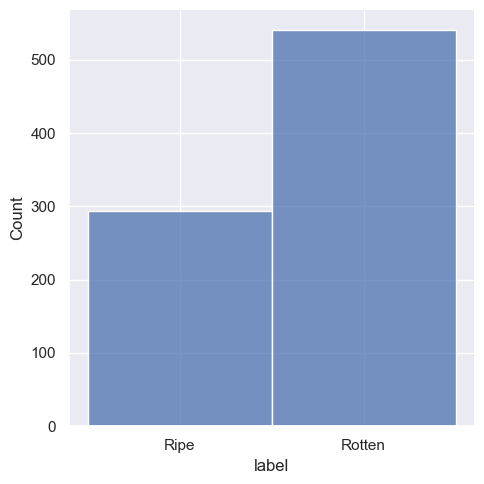

In [106]:
import seaborn as sns 

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(y, bins=30)
plt.show()

La variable a predecir consta de dos clases: Ripe y Rotten, para la realización del modelo de predicción, decidimos pasar esta variable categorica a númerica.


In [109]:
print(y)
print(type(y))
y = pd.Series(y).map({'Ripe': 1, 'Rotten': 0})

0        Ripe
1        Ripe
2        Ripe
3        Ripe
4        Ripe
        ...  
830    Rotten
831    Rotten
832    Rotten
833    Rotten
834    Rotten
Name: label, Length: 835, dtype: object
<class 'pandas.core.series.Series'>


Ahora, podemos ver que la clase Ripe será identificada como 1 y la clase Rotten como 0

## Regresión lineal

Inicialmente, se deben dividir los datos, en conjuntos de entrenamiento y de prueba. Tomando el 20% de los datos para las pruebas.

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [116]:
print("Cantidad de ejemplos para entrenamiento: ", len(X_train))
print("Cantidad de ejemplos para prueba: ", len(X_test))

Cantidad de ejemplos para entrenamiento:  668
Cantidad de ejemplos para prueba:  167


#### Uso de LinearRegresssion

Ajustamos el modelo.

In [120]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

A continuación, hacemos una predicción sobre el conjunto de pruebas y lo evaluamos.

#### Evaluación del modelo ya entrenado sobre el conjunto de pruebas seleccionado.

In [124]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred = regressor.predict(X_test)
score_r2 = r2_score(y_test,y_pred)
score_RMSE = mean_squared_error(y_test, y_pred, squared = False)
print(score_r2)
print(score_RMSE)

0.09944306159132688
0.4536041306681149


C:\Users\leidi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


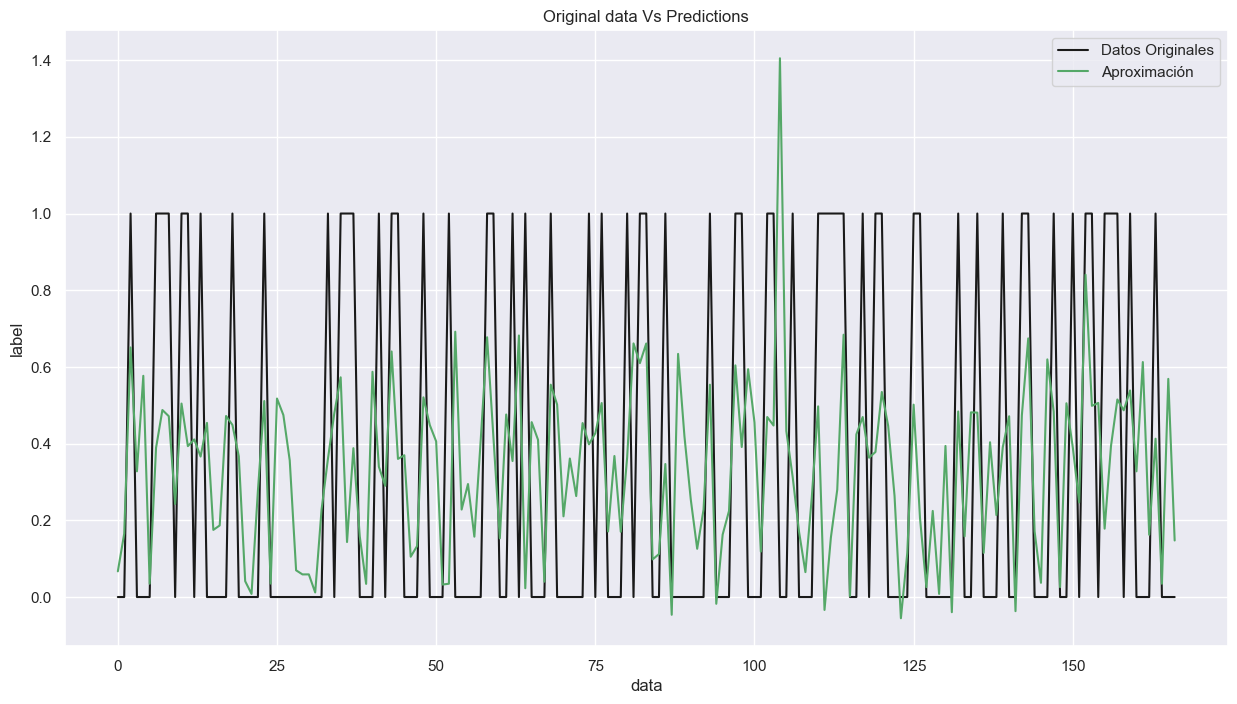

In [126]:
X = np.arange(0, len(y_test))
plt.figure(figsize=(15,8))
plt.plot(X, y_test, 'k', label='Datos Originales')
plt.plot(X, y_pred, 'g', label='Aproximación')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Original data Vs Predictions')
plt.legend()
plt.show()

Como podemos observar el modelo tiene un bajo poder predictivo; no logra explicar la mayoría de la varianza en los datos. Y además, estas predicciones tienen un error promedio de 0.4562 unidades con respecto al valor real. Podemos decir entonces, que el modelo de regresión lineal tiene un redimiento muy bajo.

## Regresión Ridge

A continuación se busca encontrar el valor de alpha que minimiza el error del modelo al predecir datos de prueba, mediante la selección de hiperparametros. Se ajusta un modelo Ridge para cada valor de alpha utilizando los datos de entrenamiento. Se calcula el RMSE (Root Mean Squared Error) y el r2 usando los datos de prueba para medir el desempeño del modelo. Y elegimos el alpha que produce el menor RMSE.

In [143]:
from sklearn.linear_model import Ridge

alphas = [1, 2.5, 5, 10]
best_alpha = None
best_rmse = float('inf')

for alpha in alphas:
    rd = Ridge(alpha=alpha)
    rd.fit(X_train, y_train)
    predicted = rd.predict(X_test)
    R2_1 = r2_score(y_test, predicted)
    rmse = mean_squared_error(y_test, predicted, squared=False)
    print(f"Alpha: {alpha}, RMSE: {rmse}, R2_1: {R2_1}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_R2_1 = R2_1
        

print(f"Best alpha: {best_alpha}, Best RMSE: {best_rmse}, BEST R2_1: {best_R2_1}")

Alpha: 1, RMSE: 0.43619377030660866, R2_1: 0.16724721727291003
Alpha: 2.5, RMSE: 0.43635221670918706, R2_1: 0.16664211625445746
Alpha: 5, RMSE: 0.43707523083874966, R2_1: 0.16387816235340857
Alpha: 10, RMSE: 0.43834834173342835, R2_1: 0.15900016403221096
Best alpha: 1, Best RMSE: 0.43619377030660866, BEST R2_1: 0.16724721727291003


C:\Users\leidi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\leidi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\leidi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\leidi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

In [145]:
print(rd.n_features_in_)

18


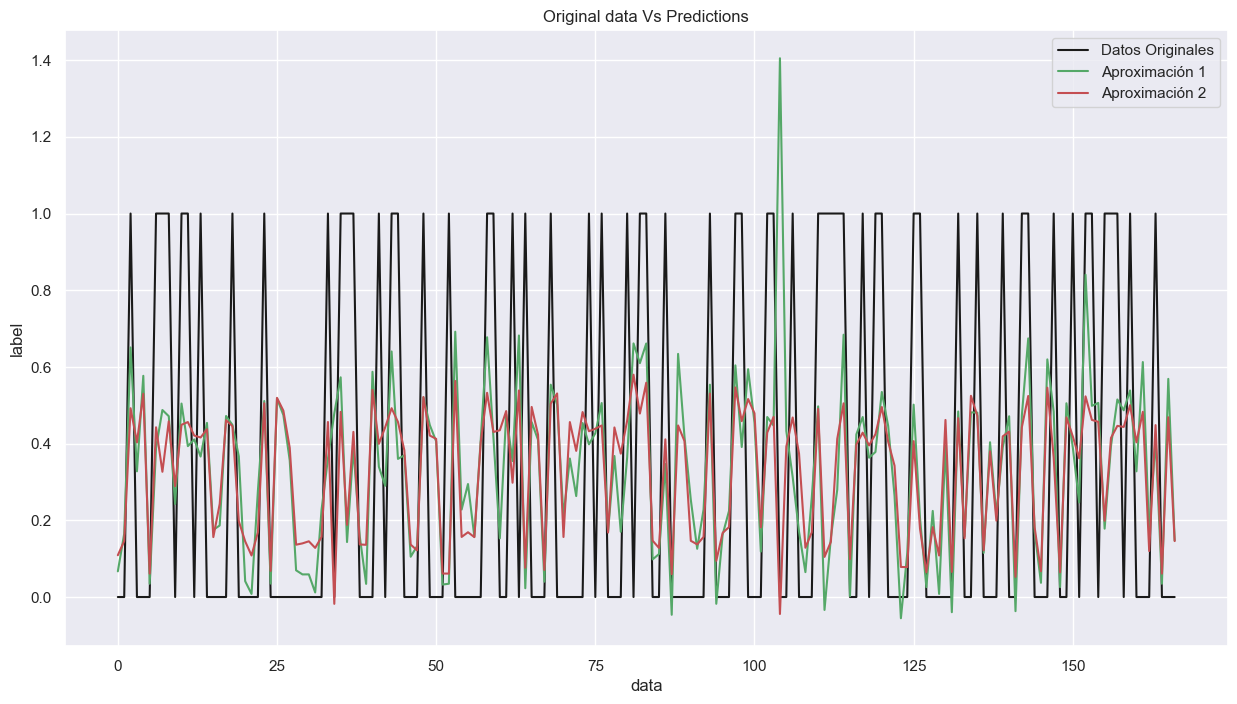

In [147]:
X = np.arange(0, len(y_test))
plt.figure(figsize=(15,8))
plt.plot(X, y_test, 'k', label='Datos Originales')
plt.plot(X, y_pred, 'g', label='Aproximación 1')
plt.plot(X, predicted, 'r', label='Aproximación 2')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Original data Vs Predictions')
plt.legend()
plt.show()

Vemos que al meter regularización mediante Ridge mejora significativamente el desempeño del modelo en comparación con el modelo lineal. Esto demuestra que regularizar los coeficientes puede ayudar a controlar el sobreajuste y producir un modelo que generaliza mejor en los datos de prueba.

Sin embargo, aunque el Ridge mejora los resultados, el R2 sigue siendo bajo.

## Regresión SoftMax

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = None, max_iter=2000)
softReg.fit(X_train,y_train)

LogisticRegression(max_iter=2000, multi_class='multinomial', penalty=None)

Para evualuar este modelo con los datos de entrenamiento: 

In [190]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
y_train_predicted_softReg = softReg.predict(X_train)

print(" Matriz de confusion para los datos de entrenamiento:\n%s" % metrics.confusion_matrix(y_train, y_train_predicted_softReg))
print('Accuracy', accuracy_score(y_train, y_train_predicted_softReg))

 Matriz de confusion para los datos de entrenamiento:
[[361  72]
 [121 114]]
Accuracy 0.7110778443113772


Ahora, con los datos de prueba:

In [193]:
y_test_predicted_softReg = softReg.predict(X_test)
print("Matriz de confusion para los datos de prueba:\n%s" % metrics.confusion_matrix(y_test, y_test_predicted_softReg))
print('Accuracy: ', accuracy_score(y_test, y_test_predicted_softReg))

Matriz de confusion para los datos de prueba:
[[93 15]
 [34 25]]
Accuracy:  0.7065868263473054


Como se logra observar, el modelo mantiene un desempeño consistente en ambos conjuntos de datos, lo cual es positivo, ya que indica que el modelo ha generalizado adecuadamente (no hay sobreajuste evidente).
Por un lado, tiene una precisión moderada en los datos de entrenamiento, con un buen número de aciertos, pero también muestra una cantidad significativa de errores, especialmente falsos negativos (121) y falsos positivos (72).
Por otro lado, en los datos de prueba, el modelo tiene una precisión similar a la de los datos de entrenamiento, lo que indica que el modelo no está sobreajustado. Sin embargo, los errores siguen siendo presentes, especialmente con los falsos negativos (34) y falsos positivos (15).

In [203]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'penalty': ['l2'],  # Regularización L2
    'C': [0.01, 0.1, 1, 10, 100],  # Diferentes valores de C
    'solver': ['lbfgs', 'saga'],  # Diferentes solvers
    'max_iter': [1000, 2000]  # Número de iteraciones
}


softReg = LogisticRegression(multi_class='multinomial', max_iter=2000)


grid_search = GridSearchCV(softReg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


print("Mejores parámetros encontrados:", grid_search.best_params_)


best_model = grid_search.best_estimator_

y_train_predicted = best_model.predict(X_train_scaled)
y_test_predicted = best_model.predict(X_test_scaled)

print("Matriz de confusión para los datos de entrenamiento:")
print(confusion_matrix(y_train, y_train_predicted))
print("Accuracy en entrenamiento:", accuracy_score(y_train, y_train_predicted))


print("Matriz de confusión para los datos de prueba:")
print(confusion_matrix(y_test, y_test_predicted))
print("Accuracy en prueba:", accuracy_score(y_test, y_test_predicted))


Mejores parámetros encontrados: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Matriz de confusión para los datos de entrenamiento:
[[360  73]
 [122 113]]
Accuracy en entrenamiento: 0.7080838323353293
Matriz de confusión para los datos de prueba:
[[94 14]
 [35 24]]
Accuracy en prueba: 0.7065868263473054


Se ajusta el modelo de regresión logística multinomial utilizando regularización L2 y se optimiza a través de GridSearchCV. Se normalizan de las características de entrada. Luego, se realiza una búsqueda de hiperparámetros para encontrar la mejor combinación de valores de penalty, C (fuerza de regularización) y solver. Y por último, el modelo entrenado con los mejores parámetros se evalúa en los conjuntos de entrenamiento y prueba, calculando la precisión y la matriz de confusión para evaluar su desempeño.

El ajuste de los parámetros de regularización y el uso de GridSearchCV han mejorado ligeramente el desempeño del modelo de regresión logística, alcanzando una precisión del 70.8% en entrenamiento y 70.7% en prueba. Es decir, presenta una correcta generalización. Sin embargo, sigue teniendo un rendimiento bajo.

## LASSO

A continuación, utilizamos la regresión logística con regularización L1 (Lasso) para realizar una clasificación multinomial. Se escalan los datos de entrenamiento. El modelo se ajusta con una penalización L1 (Lasso) utilizando el solver saga y un valor de C=0.01 para controlar la regularización. Luego, realizamos la predicción sobre los datos de entrenamiento y prueba, y se evalúa la precisión.

In [226]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [228]:
softReg_Lasso = LogisticRegression(multi_class = 'multinomial', solver = 'saga',  penalty = 'l1', C = 0.01, max_iter=5000)
softReg_Lasso.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=5000, multi_class='multinomial',
                   penalty='l1', solver='saga')

In [230]:
y_train_predicted_softReg_Lasso = softReg_Lasso.predict(X_train)
y_test_predicted_softReg_Lasso  = softReg_Lasso.predict(X_test)

print('Accuracy con los datos de entrenamiento: ', accuracy_score(y_train, y_train_predicted_softReg_Lasso))
print('Accuracy: con los datos de prueba', accuracy_score(y_test, y_test_predicted_softReg_Lasso))

Accuracy con los datos de entrenamiento:  0.6482035928143712
Accuracy: con los datos de prueba 0.6467065868263473


Los resultados muestran una precisión de aproximadamente 64.8% tanto en los datos de entrenamiento como en los de prueba, lo que indica que el modelo está teniendo un rendimiento moderado. 
Se cambiaron los parametros añadiendo más iteraciones y aumentando C, pero los resultados siguen siendo los mismos.

# Árboles de Decisión

Ahora, utilzaremos Árboles de Decisión (DecisionTreeClassifier) con el criterio de entropía y el splitter 'best' para clasificar los datos. El modelo se ajusta con un máximo de 20 niveles de profundidad. 
Después de entrenar el modelo con el conjunto de entrenamiento, lo evaluamos sobre el conjunto de prueba mediante precisión, matriz de confusión y métricas adicionales como precisión, recall, y f1-score.

#### DecisionTreeClassifier()

In [251]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=20)
clf = clf.fit(X_train,y_train)

x_data = df_properties.drop(['label'], axis=1)

y_pred = clf.predict(X_test)

print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf.score(X_test, y_test))) 
cmatrix = confusion_matrix(y_test, y_pred)
print(cmatrix)

print(classification_report(y_test, y_pred))
print(x_data.columns)

Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.83
[[95 13]
 [16 43]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       108
           1       0.77      0.73      0.75        59

    accuracy                           0.83       167
   macro avg       0.81      0.80      0.81       167
weighted avg       0.82      0.83      0.83       167

Index(['eccentricity', 'solidity', 'major_axis_length', 'minor_axis_length',
       'orientation', 'extent', 'form_factor', 'aspect_ratio', 'convex_area',
       'euler_number', 'hu_moment_2', 'hu_moment_3', 'skewness_x',
       'skewness_y', 'kurtosis_x', 'kurtosis_y', 'glcm_homogeneity',
       'glcm_energy', 'glcm_correlation', 'mean_curvature', 'std_curvature',
       'compactness', 'roundness', 'total_pixels', 'fraction_occupied',
       'boundary_pixels', 'centroid_x', 'centroid_y'],
      dtype='object')


El árbol muestra un rendimiento considerablemente sólido con una precisión general de 83%. Sin embargo, hay margen de mejora en la clasificación de la clase 1, ya que el recall para esta clase es relativamente bajo. 

In [256]:
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10)
clf = clf.fit(X_train,y_train)

x_data = df_properties.drop(['label'], axis=1)

y_pred = clf.predict(X_test)

print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf.score(X_test, y_test))) 
cmatrix = confusion_matrix(y_test, y_pred)
print(cmatrix)

print(classification_report(y_test, y_pred))
print(x_data.columns)

Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.80
[[96 12]
 [21 38]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       108
           1       0.76      0.64      0.70        59

    accuracy                           0.80       167
   macro avg       0.79      0.77      0.78       167
weighted avg       0.80      0.80      0.80       167

Index(['eccentricity', 'solidity', 'major_axis_length', 'minor_axis_length',
       'orientation', 'extent', 'form_factor', 'aspect_ratio', 'convex_area',
       'euler_number', 'hu_moment_2', 'hu_moment_3', 'skewness_x',
       'skewness_y', 'kurtosis_x', 'kurtosis_y', 'glcm_homogeneity',
       'glcm_energy', 'glcm_correlation', 'mean_curvature', 'std_curvature',
       'compactness', 'roundness', 'total_pixels', 'fraction_occupied',
       'boundary_pixels', 'centroid_x', 'centroid_y'],
      dtype='object')


Como podemos ver, el modelo con criterio Gini y máxima profundidad de 10 tiene un rendimiento sólido con una precisión del 80%. Siguen existiendo casos en donde no se clasifica correctamente la clase. Es decir, tiene un rendimiento similar al anterior.

## RandomForest: RandomForestRegressor()

Ahora utilzamos Random Forest Regressor, que es un modelo basado en un conjunto de árboles de decisión. Se ajusta a los datos de entrenamiento mediante 70 árboles (n_estimators=50) y una profundidad máxima de 10 (max_depth=20). Después de entrenar el modelo, se evalúa el rendimiento tanto en el conjunto de entrenamiento como en el conjunto de prueba utilizando el RMSE (Root Mean Squared Error) y el R2 score (coeficiente de determinación). El objetivo es comparar cómo el modelo se ajusta a los datos de entrenamiento y cómo generaliza en los datos de prueba.

In [271]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=70, max_depth=10)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=70)

In [273]:
y_train_predict2 = regr.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict2)))
r2 = r2_score(y_train, y_train_predict2)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict2 = regr.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict2)))
r2 = r2_score(y_test, y_test_predict2)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.1745564157412195
R2 score is 0.8663808213615656


The model performance for testing set
--------------------------------------
RMSE is 0.3441858480469846
R2 score is 0.48150664607572524


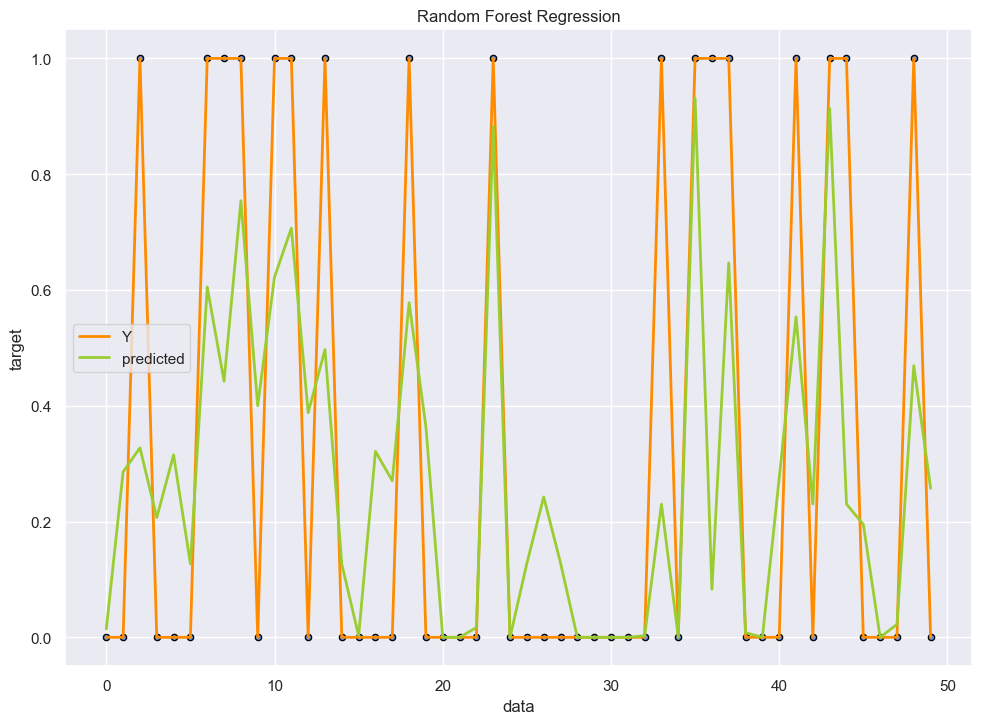

In [275]:
# Plot the results
x =  np.arange(0.0, 50)[:, np.newaxis]
plt.figure()
plt.scatter(x, y_test[:50], s=20, edgecolor="black", c="cornflowerblue")
plt.plot(x, y_test[:50], color="darkorange", label="Y", linewidth=2)
plt.plot(x, y_test_predict2[:50], color="yellowgreen", label="predicted", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

El modelo con parámetros de 70 árboles y una profundidad máxima de 10 muestra un buen desempeño en el conjunto de entrenamiento, con un R2 score de 0.8647 y un RMSE de 0.1756. Sin embargo, en el conjunto de prueba, el modelo tiene dificultades para generalizar, ya que el R2 score es de 0.4932 y el RMSE es 0.3403, lo que indica un ajuste moderado y que el modelo no captura completamente la variabilidad de los datos no vistos.

#### GridSearchCV

A continuación se utiliza el RandomForestRegressor con una búsqueda de hiperparámetros optimizados mediante GridSearchCV, que realiza la validación cruzada (cv=5) y utiliza el neg_mean_squared_error como métrica para evaluar el rendimiento de cada conjunto de hiperparámetros. Tras ajustar el modelo con los datos de entrenamiento, se obtiene el mejor conjunto de parámetros.

In [280]:
param_grid_Rf = [{'n_estimators': [60, 80],  'criterion': ['squared_error', 'absolute_error'],'max_depth': [30, 50]}] 
RfModel = RandomForestRegressor()
grid_search = GridSearchCV(RfModel, param_grid_Rf, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)   

{'criterion': 'squared_error', 'max_depth': 30, 'n_estimators': 80}


In [281]:
y_test_RfModel_predict = grid_search.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_RfModel_predict)))
r2 = r2_score(y_test, y_test_RfModel_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 0.33630464996974674
R2 score is 0.5049798019769245


Como vemos, modelo ptimizado con GridSearchCV, ha mostrado un desempeño decente con un R2 score de 0.5050, lo que significa que el modelo es capaz de explicar alrededor del 50% de la variabilidad en los datos de prueba. El RMSE de 0.3363 sugiere que la precisión del modelo es moderada, lo cual es adecuado pero no excelente.

## MLP

### MLPClassifier()

Ahora, utilizamos un modelo MLPClassifier (Multilayer Perceptron) para la clasificación, que es una red neuronal de tipo feedforward con dos capas ocultas, cada una con 5 neuronas. El modelo se entrena con el conjunto de datos de entrenamiento, utilizando una regularización (parámetro alpha) de 0.01 para evitar el sobreajuste, y un número máximo de iteraciones (max_iter) de 1000. Luego, el rendimiento del modelo se evalúa utilizando el conjunto de prueba, donde se calcula la precisión (accuracy) y la matriz de confusión para analizar cómo el modelo clasifica las instancias en cada clase.

In [344]:
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
model =  MLPClassifier(hidden_layer_sizes = (5,5), alpha=0.01, max_iter=2000) 
model.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(5, 5), max_iter=2000)

In [346]:
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predictions))

0.6766467065868264
Confusion matrix:
[[85 23]
 [31 28]]


Con un accuracy de aproximadamente 0.68, el modelo ha clasificado correctamente el 68% de los casos en el conjunto de prueba. Sin embargo, al analizar la matriz de confusión, podemos observar que existe una alta cantidad de casos en donde no se predice correctamente la clase.
Por esta razón, buscaremos un ajuste con GridSearchCV.

In [349]:
param_grid = [{'hidden_layer_sizes' : [(3,3), (4,4), (5,4)], 'max_iter':[300, 700, 1000]}, 
              {'alpha': [0.0001, 0.001, 0.01, 0.1]}]

In [351]:
model = MLPClassifier()
grid_search_param = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search_param.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'hidden_layer_sizes': [(3, 3), (4, 4), (5, 4)],
                          'max_iter': [300, 700, 1000]},
                         {'alpha': [0.0001, 0.001, 0.01, 0.1]}],
             scoring='accuracy')

In [353]:
print(grid_search_param.best_params_)

{'alpha': 0.001}


In [355]:
predictions = grid_search_param.predict(X_test)
print(accuracy_score(y_test, predictions))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predictions))

0.688622754491018
Confusion matrix:
[[87 21]
 [31 28]]


Comparado con los resultados previos, vemos una ligera mejora en el accuracy (pasando de 0.68 a 0.69) y una reducción en los falsos positivos (de 23 a 21), pero los falsos negativos siguen siendo un problema. Esta configuración de parámetros parece haber ayudado a mejorar ligeramente la clasificación, pero el modelo debe seguir optimizándose.

 # Conclusión

A partir de los modelos seleccionados, podemos concluir que con el cual se obtuvo un mejor rendimiento fue mediante Árboles de decisión con accurasy de 80% aproximadamente. Sin embargo, debido a que los resultados no son tan optimos se deberían seguir ajustando los modelos para llegar a una mejora significativa. 